## Method 2: integrate the word2vect to the first method

Training can take 6 hours or more.

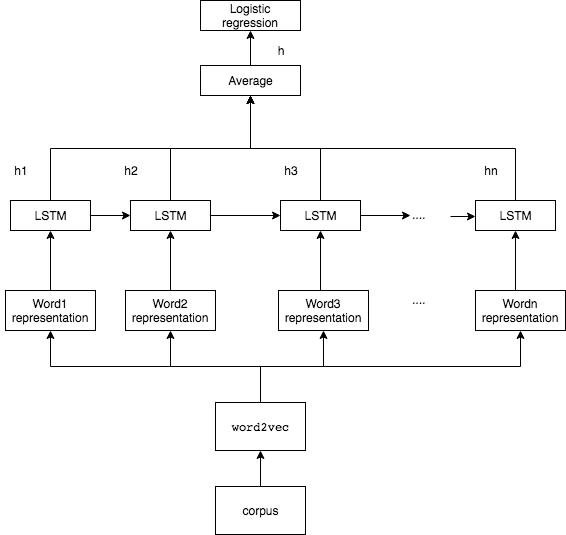

In [1]:
from IPython.display import Image
Image("../img/Method2/LSTM_Wordembedding.png")

In [2]:
from __future__ import print_function
import six.moves.cPickle as pickle

from collections import OrderedDict
import sys
import time
import numpy

import os
import theano
from theano import config
import theano.tensor as tensor
from theano.sandbox.rng_mrg import MRG_RandomStreams as RandomStreams

sys.path.append('../script')
import imdb
import Wemb_gensim

import pickle as pkl
import gensim

In [3]:
datasets = {'imdb': (imdb.load_data, imdb.prepare_data)}
SEED = 123
numpy.random.seed(SEED)

In [4]:
def adadelta(lr, tparams, grads, x, mask, y, cost):
    """
    An adaptive learning rate optimizer

    Parameters
    ----------
    lr : Theano SharedVariable
        Initial learning rate
    tpramas: Theano SharedVariable
        Model parameters
    grads: Theano variable
        Gradients of cost w.r.t to parameres
    x: Theano variable
        Model inputs
    mask: Theano variable
        Sequence mask
    y: Theano variable
        Targets
    cost: Theano variable
        Objective fucntion to minimize

    Notes
    -----
    For more information, see [ADADELTA]_.

    .. [ADADELTA] Matthew D. Zeiler, *ADADELTA: An Adaptive Learning
       Rate Method*, arXiv:1212.5701.
    """

    zipped_grads = [theano.shared(p.get_value() * numpy_floatX(0.),
                                  name='%s_grad' % k)
                    for k, p in tparams.items()]
    running_up2 = [theano.shared(p.get_value() * numpy_floatX(0.),
                                 name='%s_rup2' % k)
                   for k, p in tparams.items()]
    running_grads2 = [theano.shared(p.get_value() * numpy_floatX(0.),
                                    name='%s_rgrad2' % k)
                      for k, p in tparams.items()]

    zgup = [(zg, g) for zg, g in zip(zipped_grads, grads)]
    rg2up = [(rg2, 0.95 * rg2 + 0.05 * (g ** 2))
             for rg2, g in zip(running_grads2, grads)]

    f_grad_shared = theano.function([x, mask, y], cost, updates=zgup + rg2up,
                                    name='adadelta_f_grad_shared')

    updir = [-tensor.sqrt(ru2 + 1e-6) / tensor.sqrt(rg2 + 1e-6) * zg
             for zg, ru2, rg2 in zip(zipped_grads,
                                     running_up2,
                                     running_grads2)]
    ru2up = [(ru2, 0.95 * ru2 + 0.05 * (ud ** 2))
             for ru2, ud in zip(running_up2, updir)]
    param_up = [(p, p + ud) for p, ud in zip(tparams.values(), updir)]

    f_update = theano.function([lr], [], updates=ru2up + param_up,
                               on_unused_input='ignore',
                               name='adadelta_f_update')

    return f_grad_shared, f_update

In [5]:
def ortho_weight(ndim):
    W = numpy.random.randn(ndim, ndim)
    u, s, v = numpy.linalg.svd(W)
    return u.astype(config.floatX)

In [6]:
def _p(pp, name):
    return '%s_%s' % (pp, name)

In [7]:
# Initialize the parameters of lstm layer
def param_init_lstm(options, params, prefix='lstm'):
    """
    Init the LSTM parameter:

    :see: init_params
    """
    W = numpy.concatenate([ortho_weight(options['dim_proj']),
                           ortho_weight(options['dim_proj']),
                           ortho_weight(options['dim_proj']),
                           ortho_weight(options['dim_proj'])], axis=1)
    params[_p(prefix, 'W')] = W # _p is a function to concate prefix and W --> lstm_W
    U = numpy.concatenate([ortho_weight(options['dim_proj']),
                           ortho_weight(options['dim_proj']),
                           ortho_weight(options['dim_proj']),
                           ortho_weight(options['dim_proj'])], axis=1)
    params[_p(prefix, 'U')] = U
    b = numpy.zeros((4 * options['dim_proj'],))
    params[_p(prefix, 'b')] = b.astype(config.floatX)

    return params

In [8]:
# state_below is passed in the emb --> the weights in the first layer ? why not X
# because emb is the embedding of words which represents words
def lstm_layer(tparams, state_below, options, prefix='lstm', mask=None):
    nsteps = state_below.shape[0] # time steps namely, the number of words in a sentence
    if state_below.ndim == 3:
        n_samples = state_below.shape[1] # the number of sentences in a minibatch
    else:
        n_samples = 1 # in the case of no minibach applied, then train with one sentence at a time

    assert mask is not None # sequence mask must be provided

    def _slice(_x, n, dim):
        if _x.ndim == 3:
            return _x[:, :, n * dim:(n + 1) * dim]
        return _x[:, n * dim:(n + 1) * dim]

    # m_: mask, x_: state_below which is emb * lstm_W + lstm_b
    def _step(m_, x_, h_, c_):
        preact = tensor.dot(h_, tparams[_p(prefix, 'U')]) # lstm_U*h_t-1
        preact += x_ # Wemb * lstm_W + lstm_b + lstm_U*h_t-1

        i = tensor.nnet.sigmoid(_slice(preact, 0, options['dim_proj']))
        f = tensor.nnet.sigmoid(_slice(preact, 1, options['dim_proj']))
        o = tensor.nnet.sigmoid(_slice(preact, 2, options['dim_proj']))
        c = tensor.tanh(_slice(preact, 3, options['dim_proj']))

        c = f * c_ + i * c # c_ means previous state refer to s[t]= f*s[t-1] + i*s[t]
        c = m_[:, None] * c + (1. - m_)[:, None] * c_ # c is of shape (minibatch maxlen, number of sentences
                                                    # in a minibatch, word embbdeding size) = (98, 16, 4)
        # c = theano.printing.Print('c')(c)

        h = o * tensor.tanh(c)
        h = m_[:, None] * h + (1. - m_)[:, None] * h_

        return h, c

    # emb * lstm_W + lstm_b
    state_below = (tensor.dot(state_below, tparams[_p(prefix, 'W')]) +
                   tparams[_p(prefix, 'b')])

    dim_proj = options['dim_proj']
    # scan function, sequence is the input x, nonsequence is ussually not iterated such as w and b
    rval, updates = theano.scan(_step,
                                sequences=[mask, state_below],
                                outputs_info=[tensor.alloc(numpy_floatX(0.),
                                                           n_samples,
                                                           dim_proj),
                                              tensor.alloc(numpy_floatX(0.),
                                                           n_samples,
                                                           dim_proj)],
                                name=_p(prefix, '_layers'),
                                n_steps=nsteps) # repeat as the number of words in a sentence
    return rval[0] # rval = h which is of shape (n_samples, dim_proj)

In [9]:
def gru_layer(tparams, state_below, options, prefix='gru', mask=None):
    nsteps = state_below.shape[0]
    if state_below.ndim == 3:
        n_samples = state_below.shape[1]
    else:
        n_samples = 1

    assert mask is not None

    def _slice(_x, n, dim):
        if _x.ndim == 3:
            return _x[:, :, n * dim:(n + 1) * dim]
        return _x[:, n * dim:(n + 1) * dim]
    
    def x_seperate(_x, dim):
        if _x.ndim == 3:
            return _x[:, :, 0: 2 * dim], _x[:, :, 2 * dim:]
        return _x[:, 0: 2 * dim], _x[:, 2 * dim:]

    def _step(m_, x_, h_):
        _x12, _x3 = x_seperate(x_, model_options['dim_proj'])

        preact = tensor.dot(h_, tparams[_p(prefix, 'U')])
        preact += _x12

        m = tensor.nnet.sigmoid(preact)
        r = _slice(m, 0, model_options['dim_proj'])
        u = _slice(m, 1, model_options['dim_proj'])

        _h = tensor.tanh(_x3 + tensor.dot(r * h_, tparams[_p(prefix, 'W_hh')]))
        h = u * h_ + (1.0 - u) * _h

        h = m_[:, None] * h + (1. - m_)[:, None] * h_

        return h

    state_below = (tensor.dot(state_below, tparams[_p(prefix, 'W')]) +
                   tparams[_p(prefix, 'b')])

    dim_proj = options['dim_proj']
    initial_hidden_vector = tensor.alloc(numpy_floatX(0.), n_samples, dim_proj)

    rval, updates = theano.scan(_step,
                                sequences=[mask, state_below],
                                outputs_info=[initial_hidden_vector],
                                name=_p(prefix, '_layers'),
                                n_steps=nsteps)
    return rval[0]

In [10]:
# Initialize the parameters of gru layer
def param_init_gru(options, params, prefix='gru'):
    """
    Init the GRU parameter:

    :see: init_params
    """
    W = numpy.concatenate([ortho_weight(options['dim_proj']),
                           ortho_weight(options['dim_proj']),
                           ortho_weight(options['dim_proj'])], axis=1)
    params[_p(prefix, 'W')] = W
        
    U = numpy.concatenate([ortho_weight(options['dim_proj']),
                           ortho_weight(options['dim_proj'])], axis=1)
    params[_p(prefix, 'U')] = U

    W_hh = ortho_weight(options['dim_proj'])
    params[_p(prefix, 'W_hh')] = W_hh

    b = numpy.zeros((3 * options['dim_proj'],))
    params[_p(prefix, 'b')] = b.astype(config.floatX)

    return params

In [11]:
def vanilla_layer(tparams, state_below, options, prefix='vanilla', mask=None):
    nsteps = state_below.shape[0]
    if state_below.ndim == 3:
        n_samples = state_below.shape[1]
    else:
        n_samples = 1

    assert mask is not None

    def _step(m_, x_, h_):
        a = x_ + tensor.dot(h_, tparams[_p(prefix, 'W')])
        h = tensor.tanh(a)
        h = m_[:, None] * h + (1. - m_)[:, None] * h_
        return h

    state_below = (tensor.dot(state_below, tparams[_p(prefix, 'U')]) +
                   tparams[_p(prefix, 'b')])

    dim_proj = options['dim_proj']
    initial_hidden_vector = tensor.alloc(numpy_floatX(0.), n_samples, dim_proj)

    rval, updates = theano.scan(_step,
                                sequences=[mask, state_below],
                                outputs_info=[initial_hidden_vector],
                                name=_p(prefix, '_layers'),
                                n_steps=nsteps)
    return rval[0]

In [12]:
def param_init_vanilla(options, params, prefix='vanilla'):
    """
    Init the vanilla RNN parameter:

    :see: init_params
    """
    ndim = options['dim_proj']
    W_bound = numpy.sqrt(6. / (ndim + ndim))

    U = numpy.asarray(numpy.random.uniform(low=-W_bound, high=W_bound, size=(ndim, ndim)))
    params[_p(prefix, 'U')] = U.astype(config.floatX)
    
    W = numpy.asarray(numpy.random.uniform(low=-W_bound, high=W_bound, size=(ndim, ndim)))
    params[_p(prefix, 'W')] = W.astype(config.floatX)

    b = numpy.zeros(options['dim_proj'],)
    params[_p(prefix, 'b')] = b.astype(config.floatX)

    return params

In [13]:
# ff: Feed Forward (normal neural net), only useful to put after lstm
#     before the classifier.
layers = {'lstm': (param_init_lstm, lstm_layer), \
         'gru': (param_init_gru, gru_layer), \
         'vanilla': (param_init_vanilla, vanilla_layer)}

def get_layer(name):
    fns = layers[name]
    return fns

In [14]:
def init_params(options):
    """
    Global (not LSTM) parameters. For the embeding and the classifier.
    """
    params = OrderedDict()

    # embedding layer
    if(options['gensim_Wemb']):
        f = open('../data/gensim/gensim_imdb_Wemb.pkl', 'rb')
        Wemb = pkl.load(f)
        f.close()

        params['Wemb'] = (Wemb[:options['n_words']]).astype(config.floatX)
        # print(params['Wemb'].shape)
        assert params['Wemb'].shape[0] == options['n_words']
        assert params['Wemb'].shape[1] == options['dim_proj']
    else:
        print('wemb random initialization')
        randn = numpy.random.rand(options['n_words'],
                                  options['dim_proj']) # n_words = vocabulary size, dim_proj = word embedding size
        params['Wemb'] = (0.01 * randn).astype(config.floatX)

    # lstm layer
    params = get_layer(options['encoder'])[0](options, params, prefix=options['encoder'])

    # classifier
    params['U'] = 0.01 * numpy.random.randn(options['dim_proj'],
                                            options['ydim']).astype(config.floatX)
    params['b'] = numpy.zeros((options['ydim'],)).astype(config.floatX)

    return params

In [15]:
def init_tparams(params):
    tparams = OrderedDict()
    for kk, pp in params.items():
        tparams[kk] = theano.shared(params[kk], name=kk)
    return tparams

In [16]:
# state_before is proj namely hidden state
def dropout_layer(state_before, use_noise, trng):
    proj = tensor.switch(use_noise,
                         (state_before *
                          trng.binomial(state_before.shape,
                                        p=0.5, n=1,
                                        dtype=state_before.dtype)),
                         state_before * 0.5)
    return proj

In [17]:
def numpy_floatX(data):
    return numpy.asarray(data, dtype=config.floatX)

In [18]:
def build_model(tparams, options):
    trng = RandomStreams(SEED)

    # Used for dropout.
    use_noise = theano.shared(numpy_floatX(0.)) # --> [0], thus this line of code is the same as use_noise=[0]

    x = tensor.matrix('x', dtype='int64') # x is a sentence with each word form a row?
    mask = tensor.matrix('mask', dtype=config.floatX) # sequence mask
    y = tensor.vector('y', dtype='int64')

    n_timesteps = x.shape[0] # number of words per sentence
    n_samples = x.shape[1] # number of sentences in a minibatch

    # x.flatten() --> number_timesteps * n_samples
    emb = tparams['Wemb'][x.flatten()].reshape([n_timesteps,
                                                n_samples,
                                                options['dim_proj']]) # each word in the sentence
                                                                      # get different weights

    # call get_layer(options['encoder'])[1] --> lstm_layer --> lstm_layer(tparams,...,)
    # here emb is used to initialize states_below in lstm_layer function
    proj = get_layer(options['encoder'])[1](tparams, emb, options,
                                            prefix=options['encoder'],
                                            mask=mask)

    projshape = theano.printing.Print('proj')(proj.shape)
    # mean over word hidden representations in a sentence, proj is of shape(n_samples, dim_proj)
    if options['encoder'] == 'lstm' or options['encoder'] == 'gru':
        proj = (proj * mask[:, :, None]).sum(axis=0) # add up the hidden representations of all words in a sentence
        proj = proj / mask.sum(axis=0)[:, None] # mask.sum(axis=0) is the length of sentence without padding
    if options['use_dropout']:
        proj = dropout_layer(proj, use_noise, trng)

    # last layer
    pred = tensor.nnet.softmax(tensor.dot(proj, tparams['U']) + tparams['b'])
    # pred is the probability of a sentence belonging to a class. It is of shape (n_samples, class)

    f_pred_prob = theano.function([x, mask], pred, name='f_pred_prob')
    f_pred = theano.function([x, mask], pred.argmax(axis=1), name='f_pred')

    off = 1e-8
    if pred.dtype == 'float16':
        off = 1e-6

    # get the probability of the right class and calculate its negative log. --> negative log likelihood
    cost = -tensor.log(pred[tensor.arange(n_samples), y] + off).mean()

    return use_noise, x, mask, y, f_pred_prob, f_pred, cost

In [19]:
def get_minibatches_idx(n, minibatch_size, shuffle=False):
    """
    Used to shuffle the dataset at each iteration.
    """

    idx_list = numpy.arange(n, dtype="int32")

    if shuffle:
        numpy.random.shuffle(idx_list)

    minibatches = []
    minibatch_start = 0
    for i in range(n // minibatch_size):
        minibatches.append(idx_list[minibatch_start:
                                    minibatch_start + minibatch_size])
        minibatch_start += minibatch_size

    if (minibatch_start != n):
        # Make a minibatch out of what is left
        minibatches.append(idx_list[minibatch_start:])

    return zip(range(len(minibatches)), minibatches)

In [20]:
def unzip(zipped):
    """
    When we pickle the model. Needed for the GPU stuff.
    """
    new_params = OrderedDict()
    for kk, vv in zipped.items():
        new_params[kk] = vv.get_value()
    return new_params

In [21]:
def zipp(params, tparams):
    """
    When we reload the model. Needed for the GPU stuff.
    """
    for kk, vv in params.items():
        tparams[kk].set_value(vv)

In [22]:
def pred_error(f_pred, prepare_data, data, iterator, verbose=False):
    """
    Just compute the error
    f_pred: Theano fct computing the prediction
    prepare_data: usual prepare_data for that dataset.
    """
    valid_err = 0
    for _, valid_index in iterator:
        x, mask, y = prepare_data([data[0][t] for t in valid_index],
                                  numpy.array(data[1])[valid_index],
                                  maxlen=None)
        preds = f_pred(x, mask)
        targets = numpy.array(data[1])[valid_index]
        valid_err += (preds == targets).sum()
    valid_err = 1. - numpy_floatX(valid_err) / len(data[0])

    return valid_err

In [23]:
def get_dataset(name):
    return datasets[name][0], datasets[name][1]

In [28]:
train_costs = numpy.array([]) # add for plot
train_accus = numpy.array([])
history_errs = []
def train_model(
    encoder,
    gensim_Wemb, # Use gensim word embedding or not
    dim_proj=128,  # word embeding dimension and the number of hidden units of LSTM.
    patience=10,  # Number of epoch to wait before early stop if no progress
    max_epochs=2,  # The maximum number of epoch to run
    dispFreq=10,  # Display to stdout the training progress every N updates
    decay_c=0.,  # Weight decay for the classifier applied to the U weights.
    lrate=0.0001,  # Learning rate for sgd (not used for adadelta and rmsprop)
    n_words=100000,  # Vocabulary size actual size is about 114526
    optimizer=adadelta,  # sgd, adadelta and rmsprop available, sgd very hard to use, not recommanded
    saveto='../trained_models/Method1_and_2/lstm_model.npz',  # The best model will be saved there
    validFreq=370,  # Compute the validation error after this number of update.
    saveFreq=1110,  # Save the parameters after every saveFreq updates
    maxlen=700,  # Sequence longer then this get ignored
    batch_size=16,  # The batch size during training.
    valid_batch_size=64,  # The batch size used for validation/test set.
    dataset='imdb',
    gensim_retrain=False, # retrain word2vec or not

    # Parameter for extra option
    noise_std=0.,
    use_dropout=True,  # if False slightly faster, but worst test error
                       # This frequently need a bigger model.
    reload_model=None,  # Path to a saved model we want to start from.
    test_size=-1,  # If >0, we keep only this number of test example.
):
    global train_costs
    global train_accus
    global history_errs
    model_options = locals().copy()
    if gensim_retrain:
        path = '../data/aclImdb/'
        print('Training gensim word2vec model')
        Wemb_gensim.train_gensim_w2vec(path, Wemb_size=dim_proj, w2v_iter=20)

    # Get the function names from imdb module
    load_data, prepare_data = get_dataset(model_options['dataset'])

    print('Loading data')
    train, valid, test = load_data(
        path='../data/gensim/gensim_imdb.pkl',
        n_words=n_words,
        valid_portion=0.05)

    if test_size > 0:
        print(len(test[0]))
        idx = numpy.arange(len(test[0])) # test[0] is test_x
        numpy.random.shuffle(idx)
        idx = idx[:test_size]
        test = ([test[0][n] for n in idx], [test[1][n] for n in idx])

    # Get the number of sentimental class
    ydim = numpy.max(train[1]) + 1 # train_y = train[1]
    model_options['ydim'] = ydim

    print('Building model')
    params = init_params(model_options)

    # This create Theano Shared Variable from the parameters.
    # Dict name (string) -> Theano Tensor Shared Variable
    # params and tparams have different copy of the weights.
    tparams = init_tparams(params)

    (use_noise, x, mask,
     y, f_pred_prob, f_pred, cost) = build_model(tparams, model_options)

    # add weight decay
    if decay_c > 0.:
        decay_c = theano.shared(numpy_floatX(decay_c), name='decay_c')
        weight_decay = 0.
        weight_decay += (tparams['U'] ** 2).sum()
        weight_decay *= decay_c
        cost += weight_decay

    # define cost that includes weight decay
    f_cost = theano.function([x, mask, y], cost, name='f_cost')

    # define gradient functions
    grads = tensor.grad(cost, wrt=list(tparams.values()))
    f_grad = theano.function([x, mask, y], grads, name='f_grad')

    # define optmizer
    lr = tensor.scalar(name='lr')
    f_grad_shared, f_update = optimizer(lr, tparams, grads,
                                        x, mask, y, cost)

    print('Optimization')
    kf_valid = get_minibatches_idx(len(valid[0]), valid_batch_size)
    kf_test = get_minibatches_idx(len(test[0]), valid_batch_size)

    print("%d train examples" % len(train[0]))
    print("%d valid examples" % len(valid[0]))
    print("%d test examples" % len(test[0]))

    
    best_p = None # for storing best parameters
    bad_count = 0

    if validFreq == -1:
        validFreq = len(train[0]) // batch_size
    if saveFreq == -1:
        saveFreq = len(train[0]) // batch_size

    uidx = 0  # the number of update done
    estop = False  # early stop

   

    start_time = time.time()

    try:
        for eidx in range(max_epochs):
            n_samples = 0 # the number of sentence
            
            # Get new shuffled index for the training set.
            kf = get_minibatches_idx(len(train[0]), batch_size, shuffle=True)
            training_set_size = len(kf)
            
            for _, train_index in kf:
                uidx += 1
                use_noise.set_value(1.) # going to use noise

                # Select the random examples for this minibatch
                y = [train[1][t] for t in train_index]
                x = [train[0][t] for t in train_index] # wrap 16 sentences into an array 
                                            # as a result, x is of 2 dimensions, size of 1998/16 * 16 sentences
                # Get the data in numpy.ndarray format
                # This swap the axis!
                # Return something of shape (minibatch maxlen, n samples)
                # n_samples is the number of sentences in a minibatch
                x, mask, y = prepare_data(x, y) # all the sentence will have the same length which is minibatch maxlen
                n_samples += x.shape[1] # x.shape[1] is the number of sentence in a minibatch

                cost = f_grad_shared(x, mask, y) # call the model
                f_update(lrate)

                accuracy = (f_pred(x, mask) == y).sum() / len(y)
                train_costs = numpy.append(train_costs, cost)
                train_accus = numpy.append(train_accus, accuracy)

                if numpy.isnan(cost) or numpy.isinf(cost):
                    print('bad cost detected: ', cost)
                    break
                if numpy.mod(uidx, dispFreq) == 0:
                    remainder = (uidx % training_set_size)
                    if(remainder == 0 and uidx != 0):
                        remainder = training_set_size
                    print('Epoch ' + str(eidx + 1) + "/" + str(max_epochs) + ' Update ' + str(remainder) + "/" + str(training_set_size) + ' Cost ' + str(cost))
                    progress = (float(eidx) / float(max_epochs)) + ((float(remainder) / float(training_set_size)) / max_epochs)
                    if(progress != 0):
                        time_taken = (time.time() - start_time) / 60
                        time_remaining = time_taken / progress
                        print('Progress: %.1fmin / ' % time_taken + '%.1fmin' % time_remaining + ' (%.0f' % (progress * 100) + "%)") 

                if saveto and numpy.mod(uidx, saveFreq) == 0:
                    print('Saving...')

                    if best_p is not None:
                        params = best_p
                    else:
                        params = unzip(tparams)
                        numpy.savez(saveto, history_errs=history_errs, **params)
                        pickle.dump(model_options, open('%s.pkl' % saveto, 'wb'), -1)
                        print('Done')
                if numpy.mod(uidx, validFreq) == 0:
                    print("Validating.")
                    use_noise.set_value(0.) # at validation stage, dont use noise
                    train_err = pred_error(f_pred, prepare_data, train, kf)
                    valid_err = pred_error(f_pred, prepare_data, valid, kf_valid)
                    test_err = pred_error(f_pred, prepare_data, test, kf_test)

                    kf_valid = get_minibatches_idx(len(valid[0]), valid_batch_size)
                    kf_test = get_minibatches_idx(len(test[0]), valid_batch_size)

                    history_errs.append([valid_err, test_err])

                    if (best_p is None or
                        valid_err <= numpy.array(history_errs)[:, 0].min()):

                        best_p = unzip(tparams)
                        bad_counter = 0

                    print('Train ', train_err, 'Valid ', valid_err,
                           'Test ', test_err)

                    print("Testing for early stop criteria.")
                    print("1.) len(history_errs)=" + str(len(history_errs)) + " > patience=" + str(patience)+ "?")
                    if(len(history_errs) > patience):
                        print("2.) valid_err=" + str(valid_err) + " >= numpy.array(history_errs)[:-patience,0].min()=" + str(numpy.array(history_errs)[:-patience,0].min()) + "?")
                        if(valid_err >= numpy.array(history_errs)[:-patience,
                                                           0].min()):
                            print("bad_counter=" + str(bad_counter) + " > patience=" + str(patience) + "?")
                        
                    if (len(history_errs) > patience and
                        valid_err >= numpy.array(history_errs)[:-patience,
                                                               0].min()):
                        bad_counter += 1
                        if bad_counter > patience:
                            print('Early Stop!')
                            estop = True
                            break

            print('Seen %d samples' % n_samples)

            if estop:
                break

    except KeyboardInterrupt:
        print("Training interupted")

    
    print("Doing final calculations.")
    
    if best_p is not None:
        zipp(best_p, tparams)
    else:
        best_p = unzip(tparams)

    use_noise.set_value(0.)
    kf_train_sorted = get_minibatches_idx(len(train[0]), batch_size)
    train_err = pred_error(f_pred, prepare_data, train, kf_train_sorted)
    valid_err = pred_error(f_pred, prepare_data, valid, kf_valid)
    test_err = pred_error(f_pred, prepare_data, test, kf_test)

    print( 'Train ', train_err, 'Valid ', valid_err, 'Test ', test_err )
    if saveto:
        numpy.savez(saveto, train_err=train_err,
                    valid_err=valid_err, test_err=test_err,
                    history_errs=history_errs, **best_p)
    
    end_time = time.time()
    print('The code run for %d epochs, with %f sec/epochs' % (
        (eidx + 1), (end_time - start_time) / (1. * (eidx + 1))))
    print( ('Training took %.1fs' %
            (end_time - start_time)), file=sys.stderr)

In [ ]:
train_model(encoder='lstm', gensim_Wemb=True, dim_proj=128, n_words=5000, maxlen=400)

Loading data


2018-07-12 17:07:52,817 : INFO : loading Word2Vec object from ../data/gensim/imdb_gensim_w2vmodel
2018-07-12 17:07:54,807 : INFO : loading vocabulary recursively from ../data/gensim/imdb_gensim_w2vmodel.vocabulary.* with mmap=None
2018-07-12 17:07:54,809 : INFO : loading wv recursively from ../data/gensim/imdb_gensim_w2vmodel.wv.* with mmap=None
2018-07-12 17:07:54,811 : INFO : loading vectors from ../data/gensim/imdb_gensim_w2vmodel.wv.vectors.npy with mmap=None
2018-07-12 17:07:54,893 : INFO : setting ignored attribute vectors_norm to None
2018-07-12 17:07:54,896 : INFO : loading trainables recursively from ../data/gensim/imdb_gensim_w2vmodel.trainables.* with mmap=None
2018-07-12 17:07:54,897 : INFO : loading syn1neg from ../data/gensim/imdb_gensim_w2vmodel.trainables.syn1neg.npy with mmap=None
2018-07-12 17:07:54,965 : INFO : setting ignored attribute cum_table to None
2018-07-12 17:07:54,967 : INFO : loaded ../data/gensim/imdb_gensim_w2vmodel


Building model
Optimization
23750 train examples
1250 valid examples
25000 test examples
Epoch 1/2 Update 10/37 Cost 0.6955891929111729
Progress: 0.2min / 1.2min (14%)
Epoch 1/2 Update 20/37 Cost 0.6826609284409921
Progress: 0.3min / 1.2min (27%)
Epoch 1/2 Update 30/37 Cost 0.6888432154371318
Progress: 0.5min / 1.2min (41%)
Validating.


In [ ]:
import matplotlib.pyplot as plt

fig_tr, ax_tr = plt.subplots(1, 2, figsize=(16, 4))
fig_tr.suptitle("Cost and Accuracy on Training Set")

ax_tr[0].plot(train_costs, '-r')
ax_tr[0].set_xlabel('Iterations')
ax_tr[0].set_ylabel('Cost')

ax_tr[1].plot(train_accus, '-g')
ax_tr[1].set_xlabel('Iterations')
ax_tr[1].set_ylabel('Accuracy')

fig_tr.subplots_adjust(wspace=.4)
plt.show()

fig_v, ax_v = plt.subplots(1, 2, figsize=(16, 4))
fig_v.suptitle("Validation and test error rates")

ax_v[0].plot(numpy.array(history_errs)[:,0], '-r')
ax_v[0].set_xlabel('Iterations')
ax_v[0].set_ylabel('Validation error rate')

ax_v[1].plot(numpy.array(history_errs)[:,1], '-g')
ax_v[1].set_xlabel('Iterations')
ax_v[1].set_ylabel('Test error rate')

fig_v.subplots_adjust(wspace=.4)
plt.show()
fig_tr.savefig('../trained_models/Method1_and_2/method2_cost_and_accuracy.png')
fig_v.savefig('../trained_models/Method1_and_2/method2_validation_and_error_rate.png')